In [1]:
# packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import autograd.numpy as np
from autograd import grad, hessian
from autograd import elementwise_grad as egrad
from autograd.numpy import random 

Code for solution of the PDE $$-\Delta u + \alpha u^m = f$$ 
subject to boundary conditions $$u = g$$
on the unit box in 2D. 

There are two parameters: $\alpha$ and $m$ controlling the nonlinearity of this equation

In [2]:
# define number of collocation nodes as well as number of boundary nodes use powers of 4
dim = 2

# set parameters
alpha = 1
m = 3

# fix random seeds, for generating reference solution & sampled points
random.seed(20)

# ground truth solution
def u(x1, x2):
    return np.sin(np.pi*(2*x1+x2)) + np.sin(np.pi*(x2))+ np.sin(np.pi*(x1))

# right hand side
def f(x1, x2):
    return -egrad(egrad(u,0),0)(x1, x2)-egrad(egrad(u,1),1)(x1, x2)+alpha*(np.vectorize(u)(x1, x2)**m)

# boundary value
def g(x1, x2):
    return u(x1, x2)


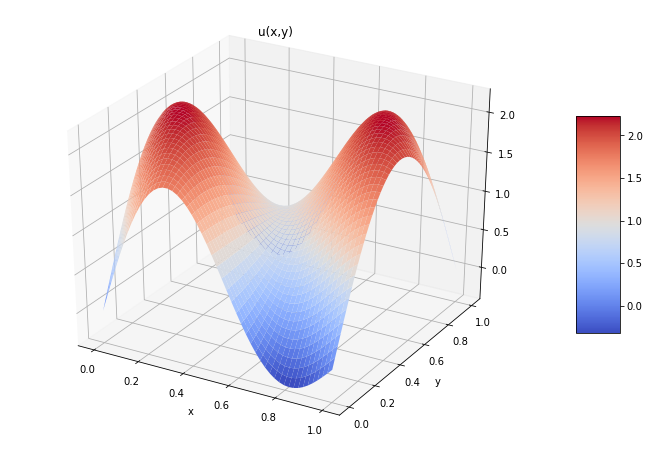

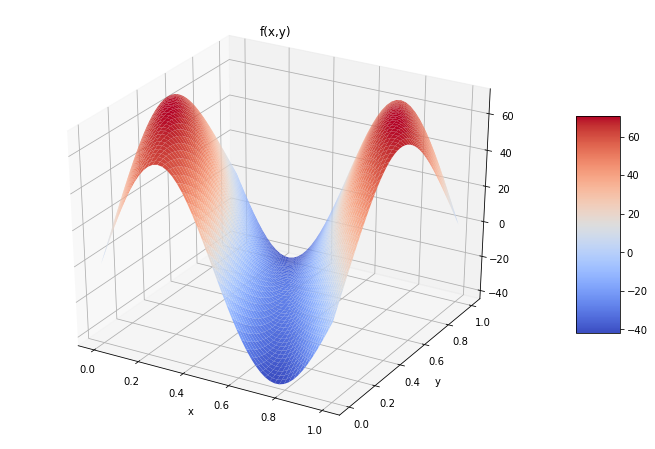

In [3]:
def plot_u(num_pts):
    xx = np.linspace(0, 1, num_pts)
    yy = np.linspace(0, 1, num_pts)
    XX, YY = np.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = np.array(XX.flatten())
    YYv = np.array(YY.flatten())

    ZZ_u = np.vectorize(u)(XXv, YYv)
    ZZ_u = ZZ_u.reshape(num_pts,num_pts)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    u_surf=ax.plot_surface(XX, YY, ZZ_u, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('u(x,y)')
    
    fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
    plt.show()

def plot_f(num_pts):
    xx = np.linspace(0, 1, num_pts)
    yy = np.linspace(0, 1, num_pts)
    XX, YY = np.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = np.array(XX.flatten())
    YYv = np.array(YY.flatten())

    ZZ_f = f(XXv, YYv)
    ZZ_f = ZZ_f.reshape(num_pts,num_pts)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    f_surf=ax.plot_surface(XX, YY, ZZ_f, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('f(x,y)')
    
    fig.colorbar(f_surf, shrink= 0.5, aspect = 5)
    plt.show()
    
plot_u(50)
plot_f(50)

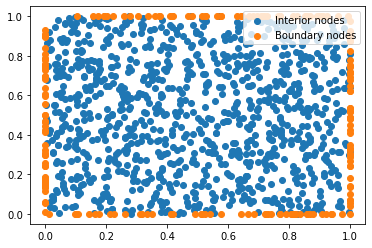

In [4]:
# sampled points

def sample_points(N_domain, N_boundary):
    # interior nodes
    X_domain = random.uniform(0.0, 1.0, (N_domain, 2))
    X_boundary = np.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 

    # bottom face
    X_boundary[range(int(N_boundary/4)), 0] = random.uniform(0.0, 1.0, int(N_boundary/4))
    # right face
    X_boundary[range(int(N_boundary/4), 2*int(N_boundary/4)), 0] += 1
    X_boundary[range(int(N_boundary/4), 2*int(N_boundary/4)), 1] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    # top face
    X_boundary[range(2*int(N_boundary/4), 3*int(N_boundary/4)), 0] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    X_boundary[range(2*int(N_boundary/4), 3*int(N_boundary/4)), 1] += 1
    # left face
    X_boundary[range(3*int(N_boundary/4), 4*int(N_boundary/4)), 1] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))

    fig, ax = plt.subplots()
    ax.scatter(X_domain[range(N_domain), 0], X_domain[range(N_domain), 1], label='Interior nodes')
    ax.scatter(X_boundary[range(N_boundary), 0], X_boundary[range(N_boundary), 1], label='Boundary nodes')
    ax.legend(loc="upper right")
    plt.show()
    return X_domain, X_boundary

N_domain_tot = 1000
N_boundary_tot = 200
X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

In [5]:
# Define a real valued kernel kappa(x, y; sigma) \to R
def kappa(x1, x2, y1, y2, sigma= 0.2):
    # x,y are 2D input row vectors
    # sigma is the variance parameter
    return np.exp(-(1/(2*sigma**2))*( (x1- y1)**2 + (x2 - y2)**2 ))

# define derivatives of the kernel 
def Delta_x_kappa(x1, x2, y1, y2, sigma):
    val = egrad(egrad(kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += egrad(egrad(kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val

def Delta_y_kappa(x1, x2, y1, y2, sigma):
    val = egrad(egrad(kappa, 2), 2)(x1, x2, y1, y2, sigma)
    val += egrad(egrad(kappa, 3), 3)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_y_kappa(x1, x2, y1, y2, sigma):
    val = egrad(egrad(Delta_y_kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += egrad(egrad(Delta_y_kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val


In [6]:
# vectorized construction of Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    Theta = np.zeros((2*N_domain + N_boundary, 2*N_domain + N_boundary))

    # auxiliary variables to make things readable
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]

    Xdb0=np.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=np.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior -- interior 
    XXdd0=np.transpose(np.tile(Xd0,(N_domain,1)))
    XXdd1=np.transpose(np.tile(Xd1,(N_domain,1)))

    # interior+boudary -- interior+bpundary
    XXdbdb0=np.transpose(np.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=np.transpose(np.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary
    XXddb0=np.transpose(np.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=np.transpose(np.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=np.tile(Xdb0,(N_domain,1))
    XXddb1_2=np.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior (Laplace)
    val = Delta_x_y_kappa(XXdd0.flatten(),XXdd1.flatten(), np.transpose(XXdd0).flatten(), np.transpose(XXdd1).flatten(), set_sigma)
    Theta[0:N_domain, 0:N_domain] =  np.reshape(val, (N_domain, N_domain))
    
    # interior+boundary v.s. interior+boundary
    val = kappa(XXdbdb0.flatten(),XXdbdb1.flatten(),np.transpose(XXdbdb0).flatten(),np.transpose(XXdbdb1).flatten(), set_sigma)
    Theta[N_domain:, N_domain:] =  np.reshape(val, (N_domain+N_boundary, N_domain+N_boundary))

    # interior v.s. interior+boundary
    val = Delta_x_kappa(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten(),set_sigma)
    Theta[:N_domain, N_domain:] = np.reshape(val, (N_domain, N_domain+N_boundary))
    Theta[N_domain:, :N_domain] = np.transpose(np.reshape(val, (N_domain, N_domain+N_boundary)))
    
    # calculate trace
    trace1 = np.trace(Theta[:N_domain, :N_domain])
    trace2 = np.trace(Theta[N_domain:, N_domain:])
    ratio = trace1/trace2
    
    temp=np.concatenate((ratio*np.ones((1,N_domain)),np.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + set_nugget*np.diag(temp[0])
    L = np.linalg.cholesky(Theta)
    
    return L, ratio

# test
set_sigma = 0.2
set_nugget = 1e-3
L, ratio = assembly_Theta(X_domain_tot, X_boundary_tot, set_nugget, set_sigma)
print('trace ratio =', ratio)
print('observation: the trace ratio is large, and our adaptive nugget term is effective')

trace ratio = 4166.666666666666
observation: the trace ratio is large, and our adaptive nugget term is effective


In the above, we added nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda I & 0 \\
0 & I 
\end{bmatrix}
\end{equation*}
where $\lambda$ is selected to be the trace ratio of the orginal Gram matrix

Then, we solve the following optimization problem:
\begin{equation*}
\begin{aligned}
\min&\quad   [v,w,u_b]\Theta_{\lambda}^{-1} [v,w,u_b]^T\\
  \text{s.t.}&\quad -v+\alpha w^m=f, \text{ and } u_b = \text{boundary data}
\end{aligned}
\end{equation*}

Here, $v,w$ represent the interior nodal values of $\Delta u(x_i), u(x_i)$, respectively.

iter = 0 J = 1351920.6191935767
iter =  1 Gauss-Newton step size = 1  J =  1654.5576334460338
iter =  2 Gauss-Newton step size = 1  J =  32.140224565046154
iter =  3 Gauss-Newton step size = 1  J =  32.0481912918265
iter =  4 Gauss-Newton step size = 1  J =  32.04819128766696
iter =  5 Gauss-Newton step size = 1  J =  32.04819128766694


Text(0.5, 1.0, 'Loss function history')

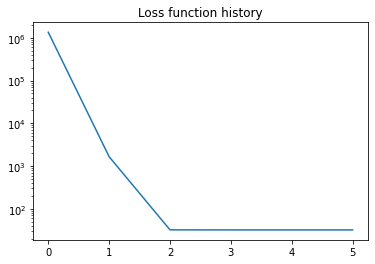

In [11]:
# loss function
def J(z,rhs_f,bdy_g,L):
    zz = np.append(alpha*(z**m) - rhs_f, z) 
    ww = np.append(zz, bdy_g)
    ss = np.linalg.solve(L, ww)
    return np.dot(ss, ss)

grad_J=grad(J)

# linearized loss function: used for GN method

# autograd construction: slow
# def GN_J(z,rhs_f,bdy_g,L,z_old):
#     zz = np.append(alpha*m*(z_old**(m-1))*(z-z_old), z) 
#     ww = np.append(zz, bdy_g)
#     ss = np.linalg.solve(L, ww)
#     return np.dot(ss, ss)
# Hessian_GN=hessian(GN_J)

# hand differentiation: fast
def Hessian_GN(z,rhs_f,bdy_g,L):
    N_domain = rhs_f.shape[0]
    N_boundary = bdy_g.shape[0]
    zz = alpha*m*(z**(m-1))
    mtx_zz = np.diag(zz)
    ww = np.concatenate((mtx_zz, np.eye(N_domain)), axis=0)
    ww = np.concatenate((ww, np.zeros((N_boundary,N_domain))), axis=0)
    ss = np.linalg.solve(L, ww)
    return 2*np.matmul(np.transpose(ss),ss)


def pde_solver(X_domain, X_boundary, nugget, max_iter, step_size, initial_sol, set_sigma):
    rhs_f = f(X_domain[:,0], X_domain[:,1])
    bdy_g = np.vectorize(u)(X_boundary[:,0], X_boundary[:,1])
    L, ratio = assembly_Theta(X_domain, X_boundary, nugget, set_sigma)

    sol = initial_sol
    J_hist = [] # history of loss function values
    J_now = J(sol,rhs_f,bdy_g,L)
    J_hist.append(J_now)
    
    print('iter = 0', 'J =', J_now) # print out history
    
    for iter_step in range(1, max_iter+1):
        temp = np.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L), grad_J(sol,rhs_f,bdy_g,L))
        sol = sol - step_size*temp  
        
        J_now = J(sol,rhs_f,bdy_g,L)
        J_hist.append(J_now)
        # print out history
        print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)               
    return sol, J_hist
    
initial_sol = random.normal(0.0, 1.0, (N_domain_tot)) # random initial guess

max_iter = 5
step_size = 1
sol, J_hist = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma)

plt.plot(np.arange(max_iter+1),J_hist)
plt.yscale("log")
plt.title('Loss function history')

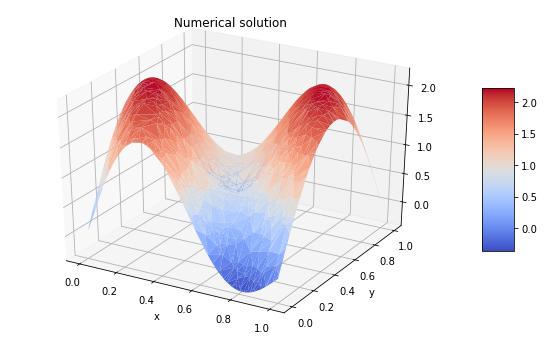

In [12]:
# scatter plot of solution at collocation nodes 
bdy_g = np.vectorize(u)(X_boundary_tot[:,0], X_boundary_tot[:,1])

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
uu = np.append(sol, bdy_g)
X_1_vals = np.append(X_domain_tot[range(N_domain_tot), 0], X_boundary_tot[range(N_boundary_tot), 0])
X_2_vals = np.append(X_domain_tot[range(N_domain_tot), 1], X_boundary_tot[range(N_boundary_tot), 1])
u_surf=ax.plot_trisurf(X_1_vals, X_2_vals, uu, cmap=plt.cm.coolwarm)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Numerical solution')
fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
plt.show()

In [13]:
# use kernel interpolation to extend the solution at test points

def construct_inpTheta(X_test, X_domain, X_boundary):
    N_test = X_test.shape[0]
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    inpTheta = np.zeros((N_test, 2*N_domain + N_boundary))

    # auxiliary variables to make things readable
    
    # X_test coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=np.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=np.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # test v.s. interior
    XXtd0=np.transpose(np.tile(Xt0,(N_domain,1)))
    XXtd1=np.transpose(np.tile(Xt1,(N_domain,1)))
    XXtd0_2=np.tile(Xd0,(N_test,1))
    XXtd1_2=np.tile(Xd1,(N_test,1))
    
    # test v.s. interior + boundary
    XXtdb0=np.transpose(np.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=np.transpose(np.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=np.tile(Xdb0,(N_test,1))
    XXtdb1_2=np.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = Delta_y_kappa(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten(),set_sigma)
    inpTheta[:,:N_domain] = np.reshape(val, (N_test, N_domain))
    
    val = kappa(XXtdb0.flatten(),XXtdb1.flatten(),XXtdb0_2.flatten(),XXtdb1_2.flatten(),set_sigma)
    inpTheta[:,N_domain:] = np.reshape(val, (N_test, N_domain+N_boundary))
    return inpTheta


def extend_solution(X_test, X_domain, X_boundary, L, v):
        
    inp_Theta = construct_inpTheta(X_test, X_domain, X_boundary)
    
    aux = np.linalg.solve(np.transpose(L),np.linalg.solve(L,v))
    
    extended_u = np.matmul(inp_Theta,aux)
    return extended_u

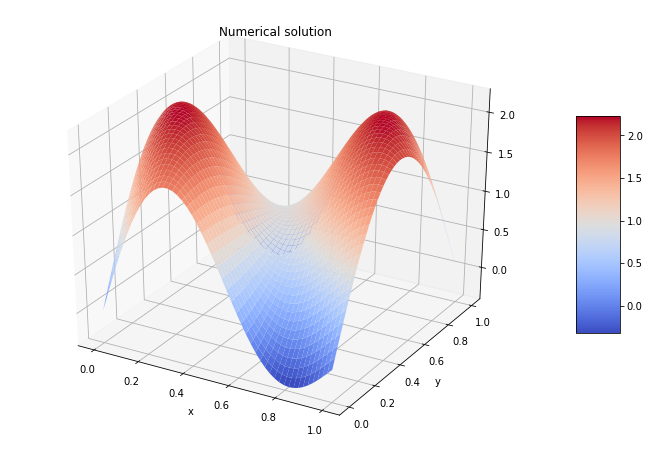

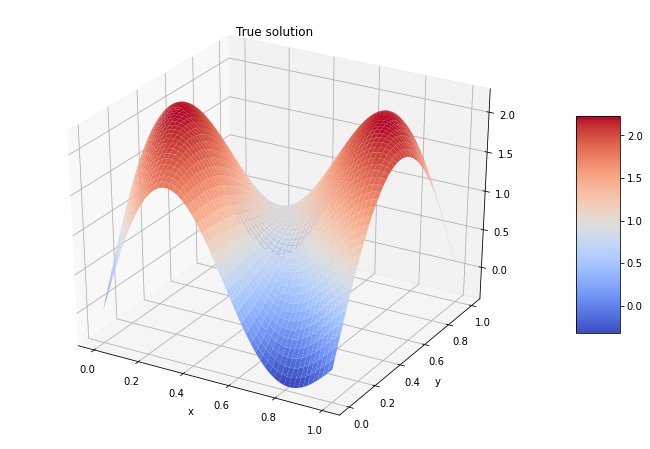

Number of collocation points:  1200 , L2 error of the solution:  0.0003765000110292902


In [14]:
# plot the extended solution in the whole domain, and calculate the errors

num_pts=50
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)

# vectorized (x,y) coordinates
XXv = np.array(XX.flatten())
YYv = np.array(YY.flatten())
XXv = np.expand_dims(XXv, axis=1) 
YYv = np.expand_dims(YYv, axis=1) 

X_test = np.concatenate((XXv,YYv), axis=1)

rhs_f = f(X_domain_tot[:,0], X_domain_tot[:,1])
bdy_g = np.vectorize(u)(X_boundary_tot[:,0], X_boundary_tot[:,1])
v = np.append(alpha*(sol**m) - rhs_f, sol) 
v = np.append(v, bdy_g)

extended_u = extend_solution(X_test, X_domain_tot, X_boundary_tot, L, v)
extended_u = extended_u.reshape(num_pts,num_pts)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_sol_surf=ax.plot_surface(XX, YY, extended_u, cmap=plt.cm.coolwarm)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Numerical solution')
fig.colorbar(u_sol_surf, shrink= 0.5, aspect = 5)
    

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
u_truth = np.vectorize(u)(XXv, YYv)
u_truth = u_truth.reshape(num_pts,num_pts)
u_truth_surf=ax.plot_surface(XX, YY, u_truth, cmap=plt.cm.coolwarm)

plt.xlabel('x')
plt.ylabel('y')
plt.title('True solution')
fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 5)

plt.show()

L2error = np.linalg.norm(extended_u-u_truth,'fro')/(num_pts)
print('Number of collocation points: ', N_domain_tot+N_boundary_tot, ', L2 error of the solution: ', L2error)